Text(0.5, 1.0, 'Original image')

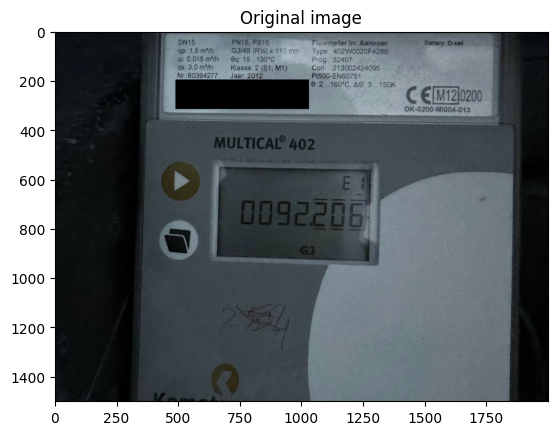

In [58]:
from matplotlib import pyplot as plt
import numpy as np
import time
import cv2

img_path = "./samples/readings-1.jpg"
east_model_path = "./frozen_east_text_detection.pb"
min_confidence = 0.5
nms_threshold = 0.9

# Maintain approximate aspect ratio of 3:4 but make sure image size is multiple of 32
# which is necessary for EAST
img_resize_width = 1280
img_resize_height = 960

# Load the input image and grab the image dimensions
image = cv2.imread(img_path)
orig = image.copy()

def draw_bounding_box(img, box, ratio_width, ratio_height):
    (start_x, start_y, end_x, end_y) = box

    # Scale the bounding box coordinates based on the respective ratios
    start_x = int(start_x * ratio_width)
    start_y = int(start_y * ratio_height)
    end_x = int(end_x * ratio_width)
    end_y = int(end_y * ratio_height)

    # Draw the bounding box on the image
    cv2.rectangle(img, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)

plt.imshow(orig)
plt.title("Original image")

Text(0.5, 1.0, 'Resized image for EAST')

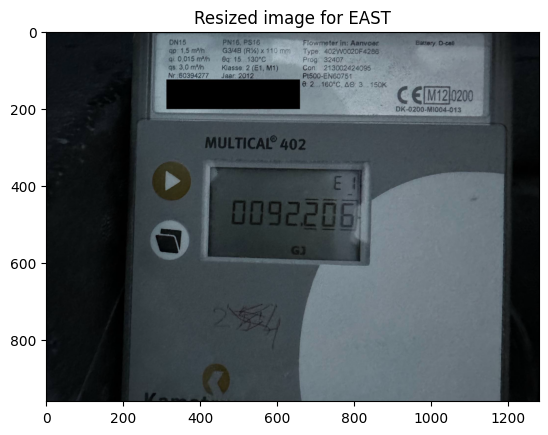

In [59]:
(original_height, original_width) = image.shape[:2]

# Set the new width and height and then determine the ratio in change
# for both the width and height
resize_ratio_width = original_width / float(img_resize_width)
resize_ratio_height = original_height / float(img_resize_height)

# Resize the image and grab the new image dimensions
image = cv2.resize(image, (img_resize_width, img_resize_height))
(resized_height, resized_width) = image.shape[:2]

plt.imshow(image)
plt.title("Resized image for EAST")

In [60]:
# Define the two output layer names for the EAST detector model that
# we are interested — the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layer_names = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"
]

# Load the pre-trained EAST text detector
print("[INFO] Loading EAST text detector...")
net = cv2.dnn.readNet(east_model_path)

[INFO] Loading EAST text detector...


In [61]:
# Construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (resized_width, resized_height), (123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layer_names)
end = time.time()

# Show timing information on text prediction
print("[INFO] Text detection took {:.6f} seconds".format(end - start))

[INFO] Text detection took 1.409268 seconds


Text(0.5, 1.0, 'Original image with 66 detected text blocks')

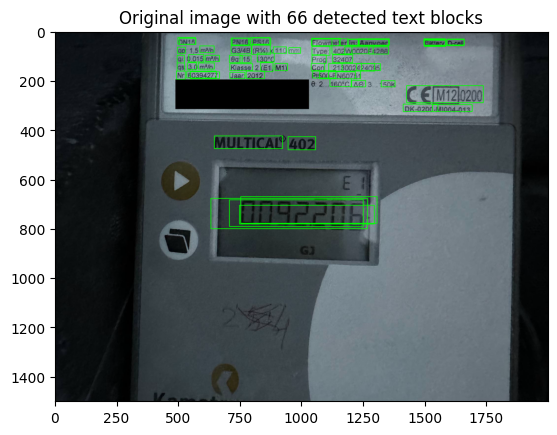

In [62]:
# Grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(num_rows, num_cols) = scores.shape[2:4]
boxes = []
confidences = []
# loop over the number of rows
for y in range(0, num_rows):
	# Extract the scores (probabilities), followed by the geometrical
	# data used to derive potential bounding box coordinates that
	# surround text
	scores_data = scores[0, 0, y]
	x_data0 = geometry[0, 0, y]
	x_data1 = geometry[0, 1, y]
	x_data2 = geometry[0, 2, y]
	x_data3 = geometry[0, 3, y]
	angles_data = geometry[0, 4, y]
	
	# Loop over the number of columns
	for x in range(0, num_cols):
		# If our score does not have sufficient probability, ignore it
		if scores_data[x] < min_confidence:
			continue
		# Compute the offset factor as our resulting feature maps will
		# be 4x smaller than the input image
		(offset_x, offset_y) = (x * 4.0, y * 4.0)
		# Extract the rotation angle for the prediction and then
		# compute the sin and cosine
		angle = angles_data[x]
		cos = np.cos(angle)
		sin = np.sin(angle)
		# Use the geometry volume to derive the width and height of
		# the bounding box
		h = x_data0[x] + x_data2[x]
		w = x_data1[x] + x_data3[x]
		# Compute both the starting and ending (x, y)-coordinates for
		# the text prediction bounding box
		end_x = int(offset_x + (cos * x_data1[x]) + (sin * x_data2[x]))
		end_y = int(offset_y - (sin * x_data1[x]) + (cos * x_data2[x]))
		start_x = int(end_x - w)
		start_y = int(end_y - h)
		# Add the bounding box coordinates and probability score to
		# our respective lists
		boxes.append((start_x, start_y, end_x, end_y))
		confidences.append(scores_data[x])

# Apply non-max suppression
box_indexes = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, nms_threshold)

# Draw filtered bounding boxes
for i in box_indexes:
	draw_bounding_box(orig, boxes[i], resize_ratio_width, resize_ratio_height)

plt.imshow(orig)
plt.title(f"Original image with {len(box_indexes)} detected text blocks")